In [1]:
import numpy as np
import pyuvdata
import matplotlib
import matplotlib.pyplot as plt
import os
import importlib
importlib.reload(pyuvdata)
from IPython.display import Image


In [27]:
use_files = [
    "zen.2459861.45004.sum.abs_calibrated.red_avg",
    "zen.2459861.48427.sum.abs_calibrated.red_avg",
    "zen.2459861.48002.sum.abs_calibrated.red_avg",
]

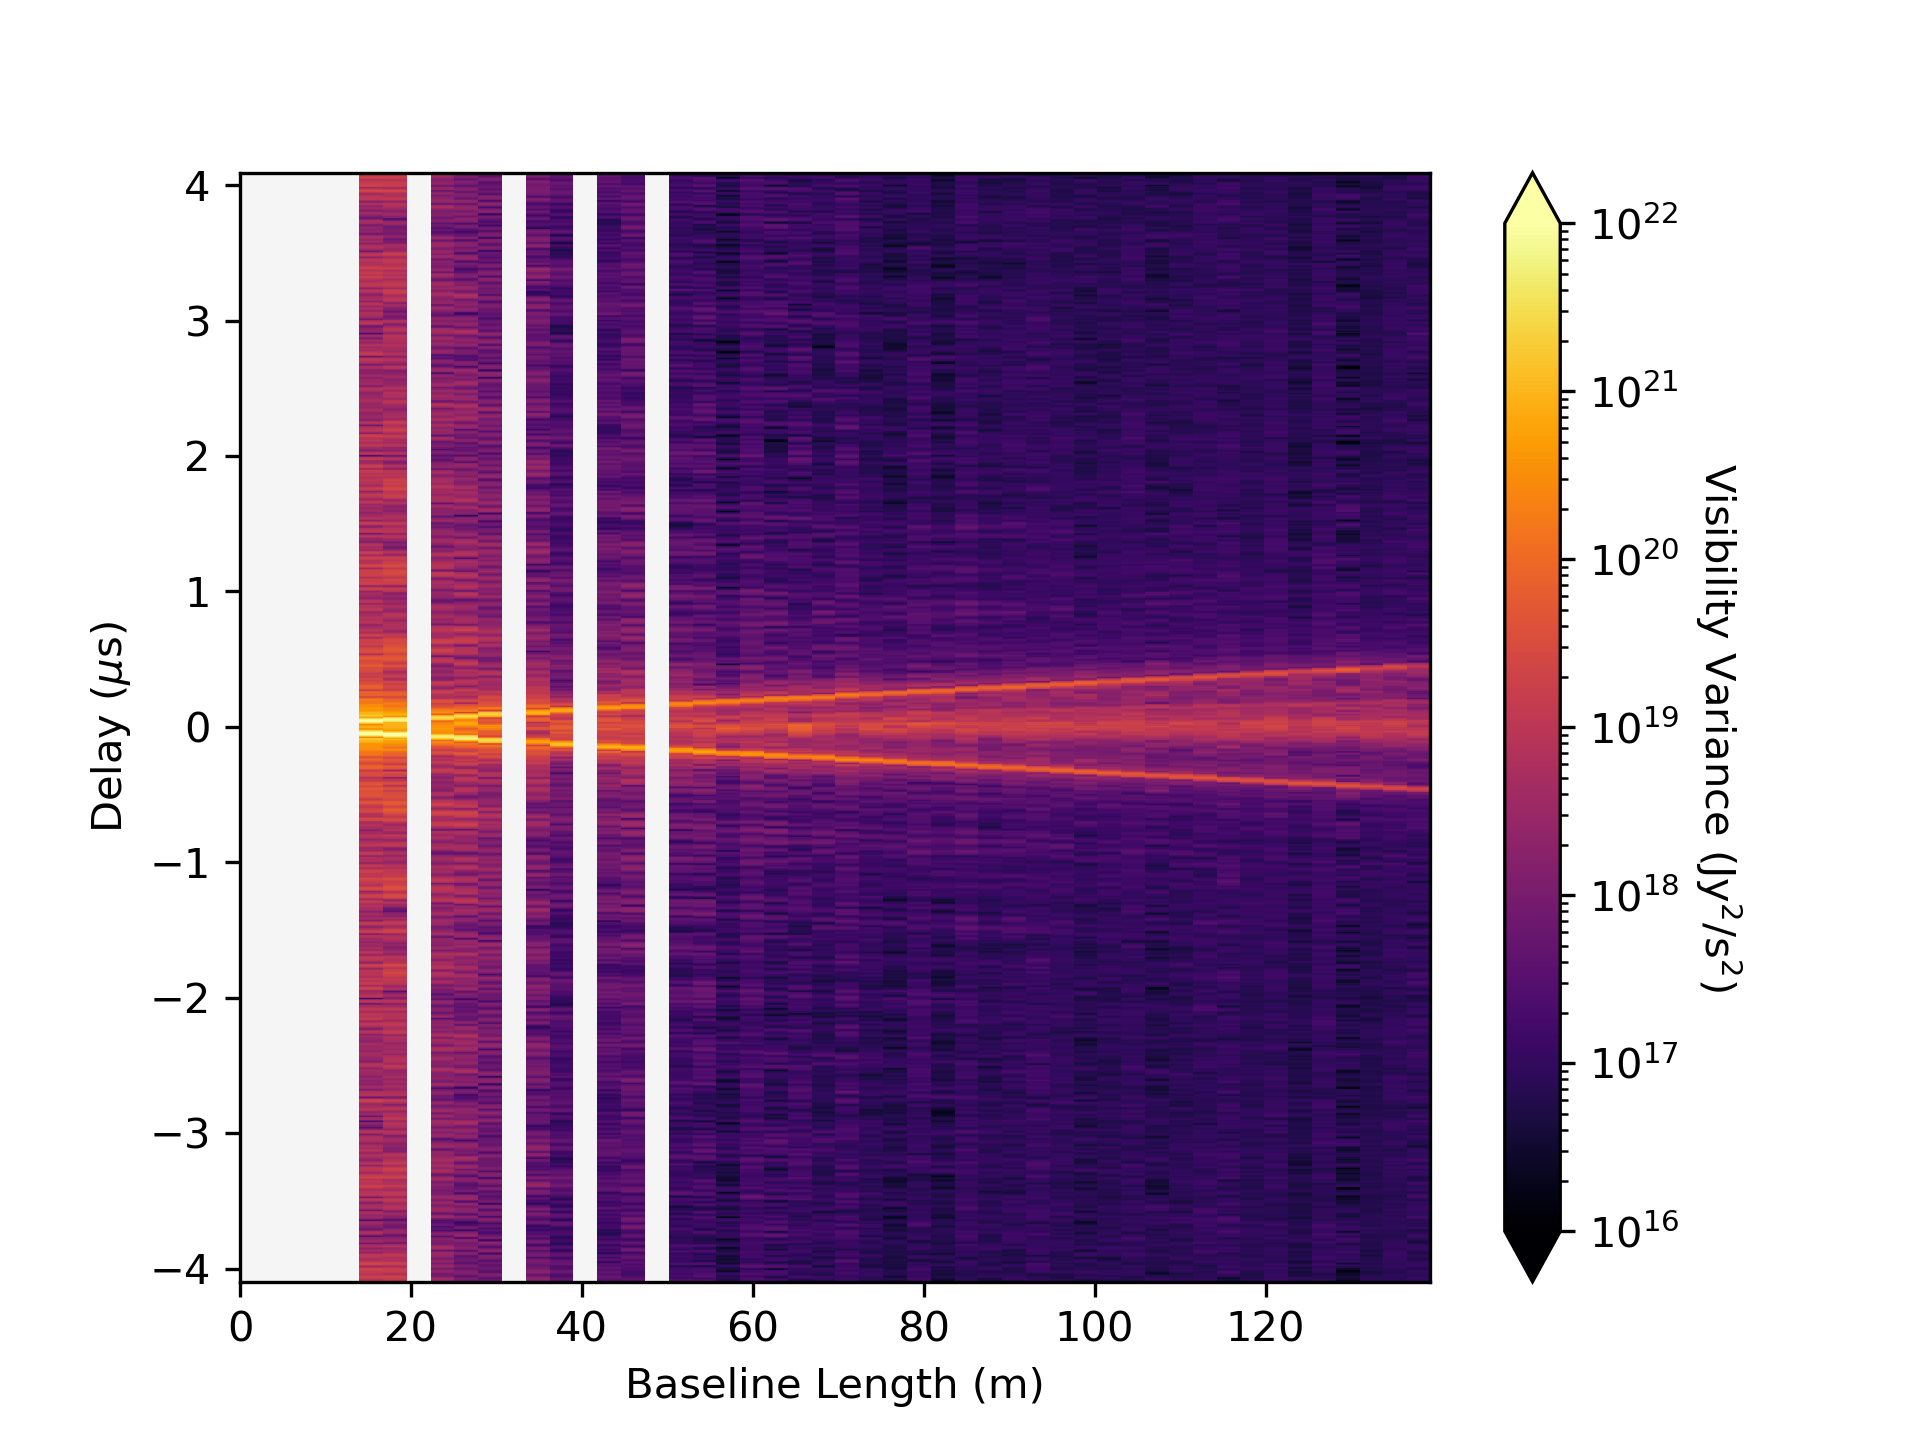

In [38]:
Image(
    filename=f"/safepool/rbyrne/hera_abscal_Jun2024/delay_spectrum_plots/zen.2459861.45004.sum.abs_calibrated.red_avg_data.png"
)

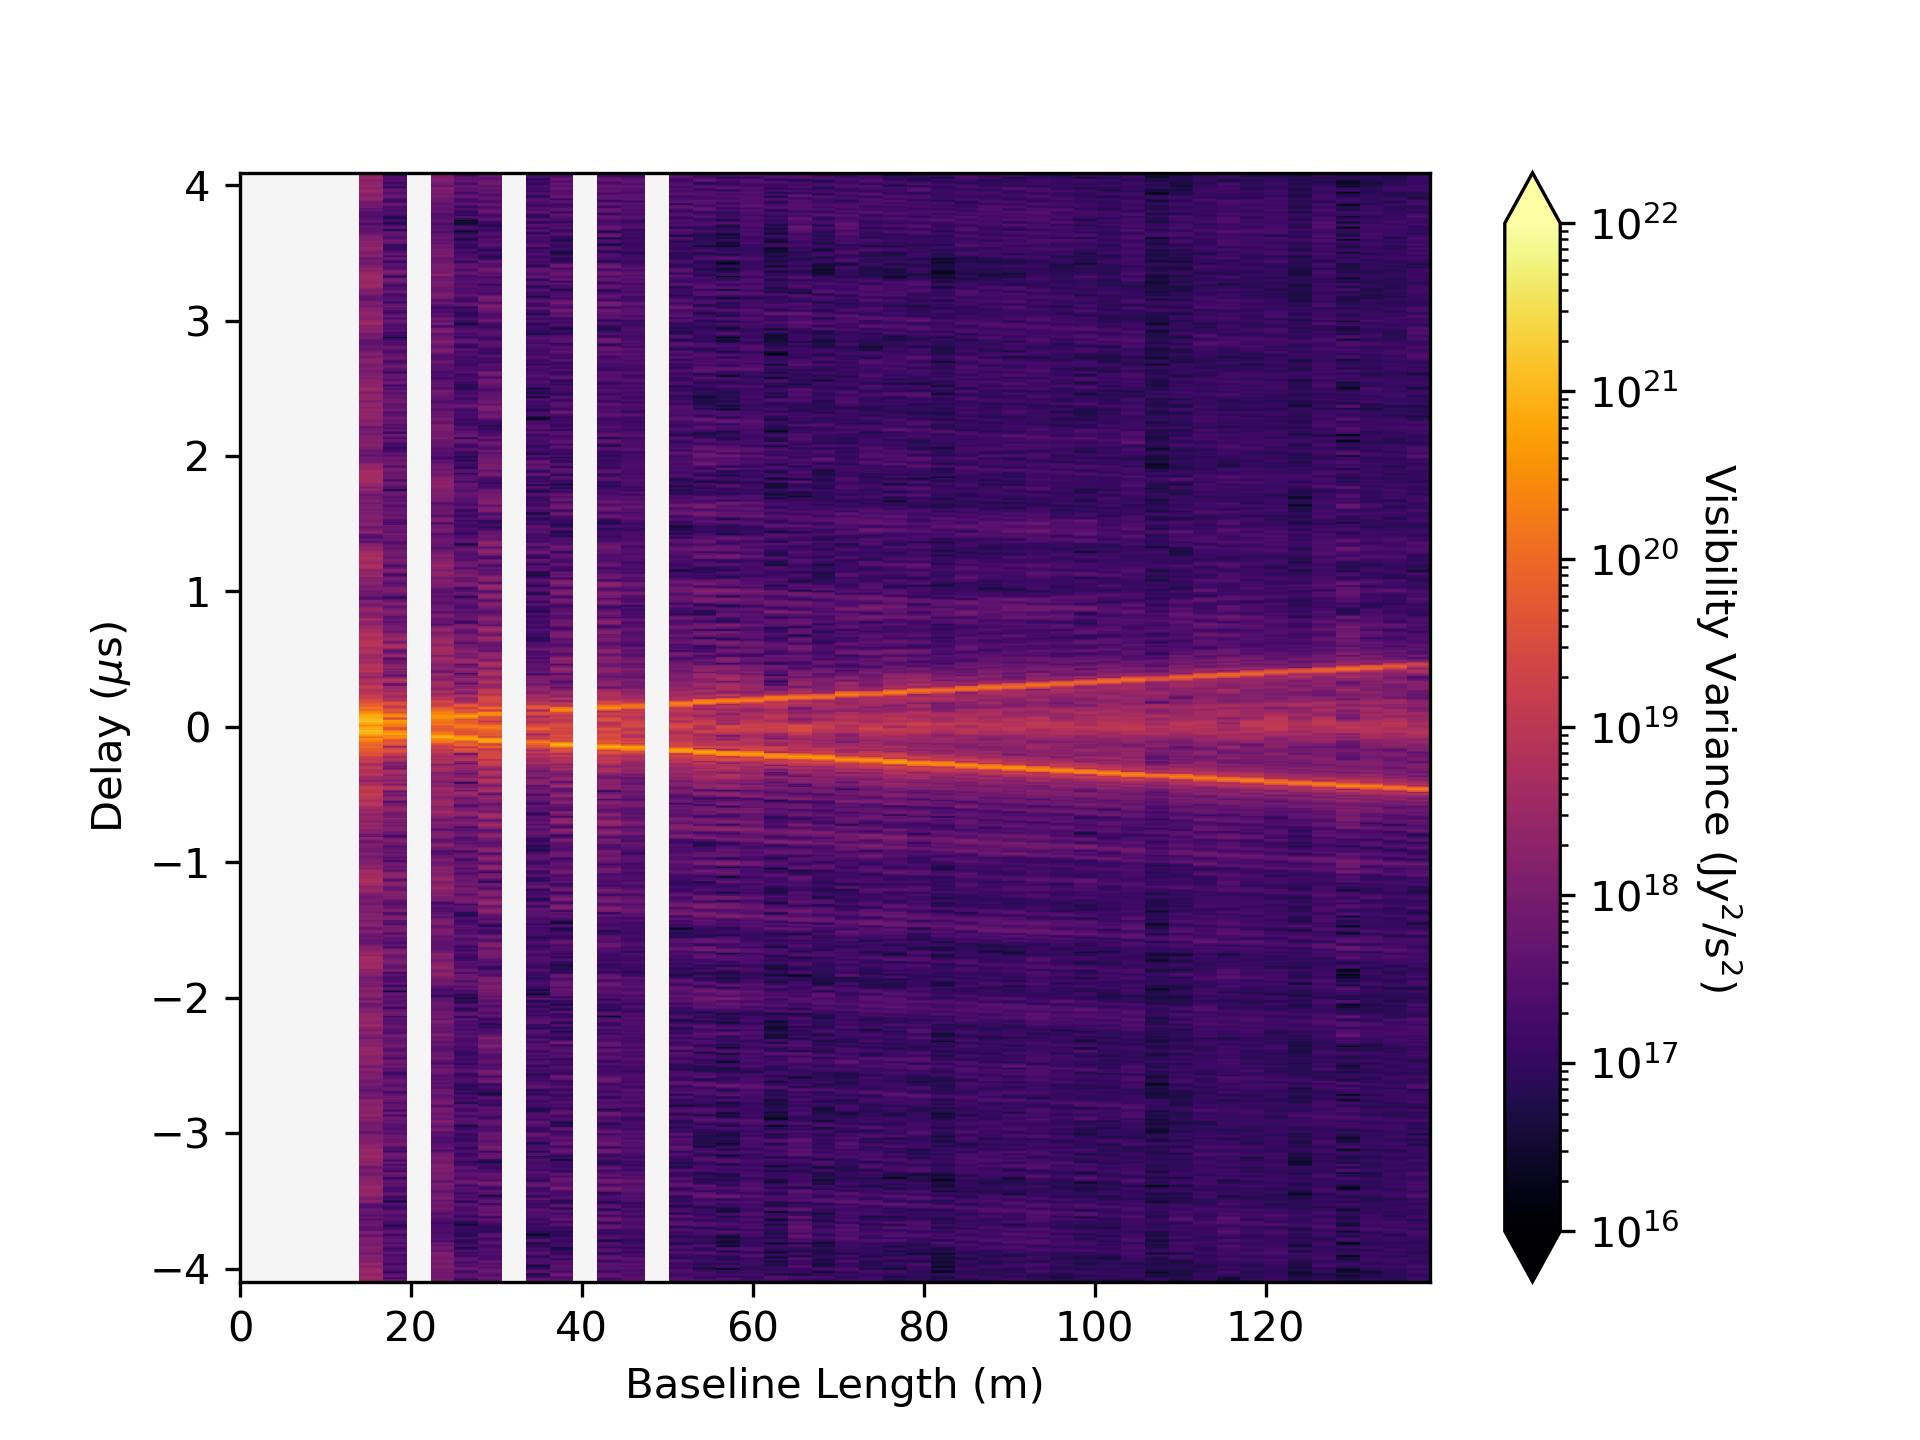

In [39]:
Image(
    filename=f"/safepool/rbyrne/hera_abscal_Jun2024/delay_spectrum_plots/zen.2459861.45004.sum.abs_calibrated.red_avg_diff.png"
)

In [11]:
data_orig = pyuvdata.UVData()
data_orig.read(
    "/safepool/rbyrne/hera_data/H6C-data/2459861/zen.2459861.43595.sum.abs_calibrated.red_avg.uvh5"
)
# model = pyuvdata.UVData()
# model.read("/safepool/rbyrne/hera_data/interpolated_models/zen.2459861.52096.sum.abs_calibrated.red_avg_model.uvfits")
data_abscal = pyuvdata.UVData()
data_abscal.read(
    "/safepool/rbyrne/hera_abscal_Jun2024/zen.2459861.43595.sum.abs_calibrated.red_avg_abscal.uvfits"
)
data_dwabscal = pyuvdata.UVData()
data_dwabscal.read(
    "/safepool/rbyrne/hera_abscal_Jun2024/zen.2459861.43595.sum.abs_calibrated.red_avg_dwabscal_normalized.uvfits"
)
# data.read("/safepool/rbyrne/hera_data/H4C-Abscal-Model/zen.2458894.16911.uvh5")

In [12]:
abscal_params = np.load(
    "/safepool/rbyrne/hera_abscal_Jun2024/zen.2459861.47868.sum.abs_calibrated.red_avg_dwabscal_params.npy"
)

In [13]:
np.shape(abscal_params)

(3, 1536, 2)

In [14]:
def plot_visibilities(uvdata):
    
    use_data = np.copy(uvdata.data_array)
    use_data[np.where(uvdata.flag_array)] = 0  # Zero out flagged data

    # FFT across frequency
    delay_array = np.fft.fftfreq(uvdata.Nfreqs, d=uvdata.channel_width)
    delay_array = np.fft.fftshift(delay_array)
    fft_abs = np.abs(np.fft.fftshift(np.fft.fft(use_data, axis=2), axes=2))
    fft_abs *= uvdata.channel_width

    # Average in baseline length bins
    nbins = 50
    bl_lengths = np.sqrt(np.sum(uvdata.uvw_array**2.0, axis=1))
    bl_bin_edges = np.linspace(np.min(bl_lengths), np.max(bl_lengths), num=nbins + 1)
    binned_variance = np.full([nbins, uvdata.Nfreqs], np.nan, dtype="float")
    for bin_ind in range(nbins):
        bl_inds = np.where(
            (bl_lengths > bl_bin_edges[bin_ind])
            & (bl_lengths <= bl_bin_edges[bin_ind + 1])
        )[0]
        if len(bl_inds) > 0:
            binned_variance[bin_ind, :] = np.mean(
                fft_abs[bl_inds, 0, :, 0] ** 2.0, axis=0
            )

    # Plot
    use_cmap = matplotlib.cm.get_cmap("inferno")
    use_cmap.set_bad(color="whitesmoke")
    vmin = 1e16
    vmax = 1e22
    norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
    plt.imshow(
        binned_variance.T,
        origin="lower",
        interpolation="none",
        cmap=use_cmap,
        norm=norm,
        extent=[
            np.min(bl_bin_edges),
            np.max(bl_bin_edges),
            np.min(delay_array) * 1e6,
            np.max(delay_array) * 1e6,
        ],
        aspect="auto",
    )

    # Add horizon lines
    if False:
        plt.plot(
            [np.min(bl_bin_edges), np.max(bl_bin_edges)],
            [
                np.min(bl_bin_edges) / 3e8 * 1e6,
                np.max(bl_bin_edges) / 3e8 * 1e6,
            ],
            "--",
            color="white",
            linewidth=1.0,
        )
        plt.plot(
            [np.min(bl_bin_edges), np.max(bl_bin_edges)],
            [
                -np.min(bl_bin_edges) / 3e8 * 1e6,
                -np.max(bl_bin_edges) / 3e8 * 1e6,
            ],
            "--",
            color="white",
            linewidth=1.0,
        )

    cbar = plt.colorbar(extend="both")
    cbar.ax.set_ylabel(
        "Mean Visibility Power (Jy$^{2}$/s$^2$)", rotation=270, labelpad=15
    )
    plt.xlabel("Baseline Length (m)")
    plt.ylim([np.min(delay_array) * 1e6, np.max(delay_array) * 1e6])
    plt.ylabel("Delay ($\mu$s)")
    plt.show()

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


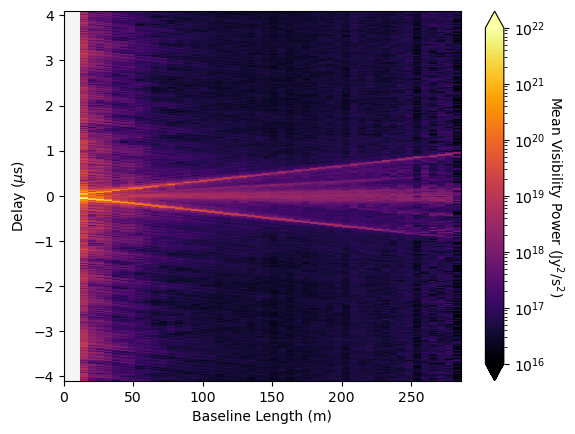

In [15]:
plot_visibilities(data_orig)

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


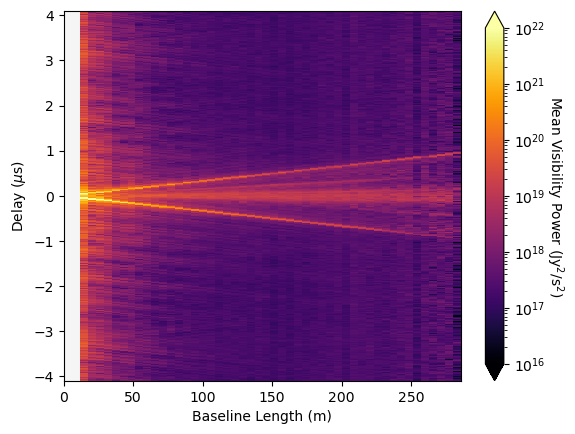

In [16]:
plot_visibilities(data_abscal)

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


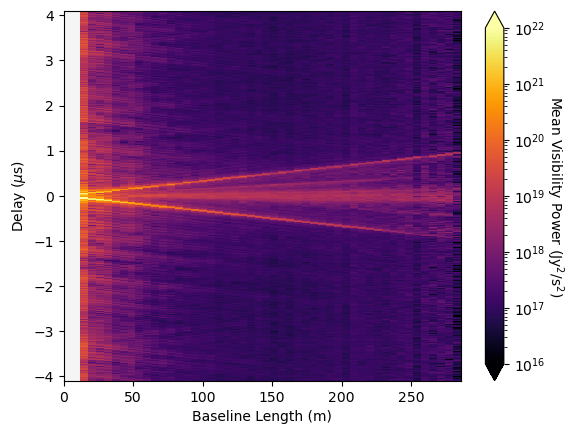

In [17]:
plot_visibilities(data_dwabscal)

In [40]:
avg_spectra = np.load(
    "/safepool/rbyrne/hera_abscal_Jun2024/mean_variance_abscal_nbins50_xx_debug.npz"
)

In [41]:
np.nanmean(avg_spectra["variance"])

3.638814568174735e+18

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


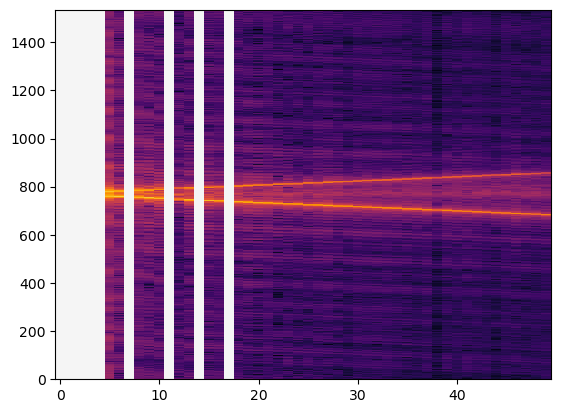

In [42]:
use_cmap = matplotlib.cm.get_cmap("inferno")
use_cmap.set_bad(color="whitesmoke")
vmin = 1e16
vmax = 1e22
norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
plt.imshow(
    avg_spectra["variance"].T,
    origin="lower",
    interpolation="none",
    cmap=use_cmap,
    norm=norm,
    aspect="auto",
)
plt.show()

In [ ]:
abscal_params = np.load(
    "/safepool/rbyrne/hera_abscal/zen.2459861.48181.sum.abs_calibrated.red_avg_abscal_params.npy"
)

In [ ]:
np.shape(abscal_params)

(3, 1536, 2)

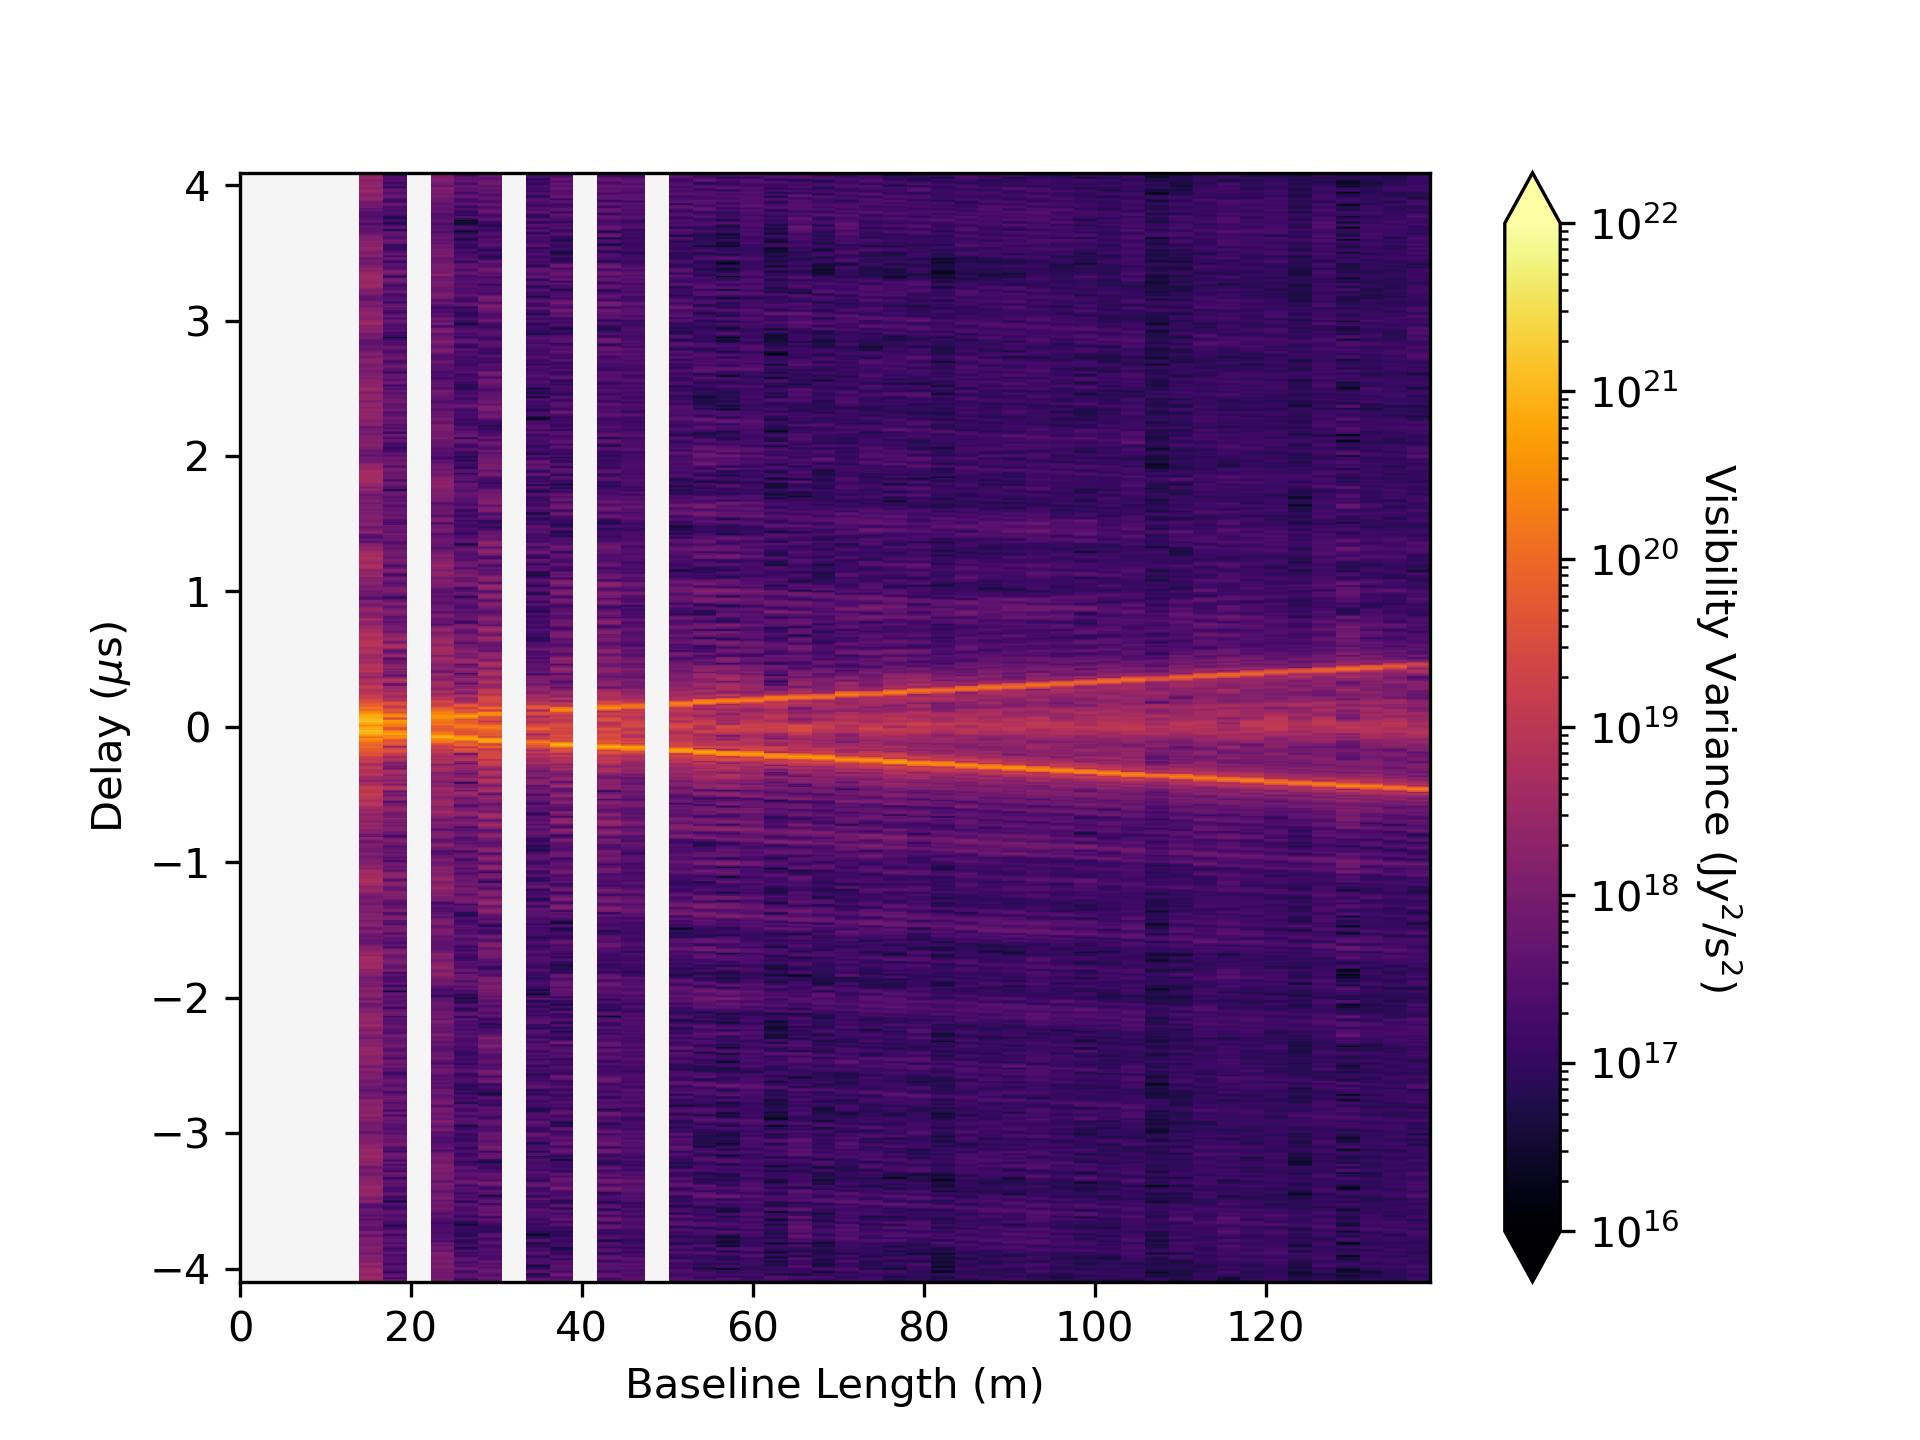

In [ ]:
from IPython.display import Image
Image(
    filename="/safepool/rbyrne/hera_abscal_Jun2024/delay_spectrum_plots/zen.2459861.45004.sum.abs_calibrated.red_avg_diff.png"
)